## Registration method - Deformation Field

Author: Felipe Cortes Jaramillo

Date: 11 November, 2023

For this method we register different images from lasers using a method inspired in VoxelMorph alrgorithm: https://github.com/voxelmorph/voxelmorph

In [1]:
# First, we are going to download the library
!pip install voxelmorph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pystrum: filename=pystrum-0.4-py3-none-any.whl size=19533 sha256=87681efdb296129e99b5d4474100dc6d3389189731dea4207d23493c1c85017a
  Stored in directory: /root/.cache/pip/wheels/aa/08/d0/914025beb5a12a855b8aafd22eeedc547198684a3f4409f66c
Successfully built pystrum


In [2]:
# Importing dependencies
import os, sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tqdm
from PIL import Image
import glob
assert tf.__version__.startswith('2.'), 'This requires Tensorflow 2.0+'

# Importing special dependencies
import voxelmorph as vxm
import neurite as ne

In [3]:
# We mount Colab for this
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Data adquisiton - Pre-processing
We download the data and apply some simple pre-processing!

In [4]:
# Let's load the data
images_route_24_30 = './drive/MyDrive/24_30_cropped/all/'
images_route_22_30 = './drive/MyDrive/22_30_cropped/all/'
images_route_20_2  = './drive/MyDrive/20_2_cropped/all/'

filelist_24_30  = sorted(glob.glob(f'{images_route_24_30}*.jpg'))
filelist_22_30 = sorted(glob.glob(f'{images_route_22_30}*.jpg'))
filelist_20_2 = sorted(glob.glob(f'{images_route_20_2}*.jpg'))

data_set_24_30 = np.array([np.array(Image.open(fname).convert('L')) for fname in filelist_24_30])
data_set_22_30 = np.array([np.array(Image.open(fname).convert('L')) for fname in filelist_22_30])
data_set_20_2 = np.array([np.array(Image.open(fname).convert('L')) for fname in filelist_20_2])


# Print shapes
print(f"Shape of data 24_30 set: {data_set_24_30.shape}")
print(f"Shape of data 22_30 set: {data_set_22_30.shape}")
print(f"Shape of data 20_2 set: {data_set_20_2.shape}")

Shape of data 24_30 set: (50, 224, 224)
Shape of data 22_30 set: (50, 512, 512)
Shape of data 20_2 set: (50, 512, 512)


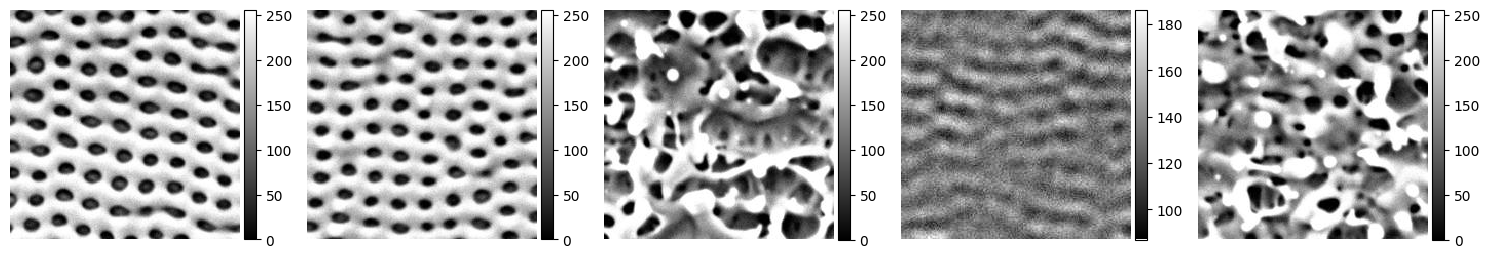

In [5]:
# We can visualize some of the data from the first set

nb_vis = 5
# choose nb_vis sample indexes
idx = np.random.choice(data_set_24_30.shape[0], nb_vis, replace=False)
example_digits = [f for f in data_set_24_30[idx, ...]]

# plot
ne.plot.slices(example_digits, cmaps=['gray'], do_colorbars=True);

In [6]:
# We normalize the data to be in range [0 - 1]
norm_data_set_24_30 = data_set_24_30.astype('float')/255
norm_data_set_22_30 = data_set_22_30.astype('float')/255
norm_data_set_20_2  = data_set_20_2.astype('float')/255

# Verify
print('Set of 24_30 maximum value', norm_data_set_24_30.max())
print('Set of 22_30 maximum value', norm_data_set_22_30.max())
print('Set of 20_2 maximum value', norm_data_set_20_2.max())

Set of 24_30 maximum value 1.0
Set of 22_30 maximum value 1.0
Set of 20_2 maximum value 1.0


In [33]:
# We can add optionally a padding if we want to achieve a desired shape
#pad_amount = ((0, 0), (16,16), (16,16))
pad_amount = ((0, 0), (0, 0), (0, 0))

# fix data
x_24_30 = np.pad(norm_data_set_24_30, pad_amount, 'constant')
x_22_30 = np.pad(norm_data_set_22_30, pad_amount, 'constant')
x_20_2  = np.pad(norm_data_set_20_2, pad_amount, 'constant')

# verify
print('Shape of 24_30 training data', x_24_30.shape)
print('Shape of 22_30 training data', x_22_30.shape)
print('Shape of 20_2 training data', x_20_2.shape)


Shape of 24_30 training data (50, 224, 224)
Shape of 22_30 training data (50, 512, 512)
Shape of 20_2 training data (50, 512, 512)


In [12]:
# --- Training the model - Sequenced Generator ---

def vxm_data_seq_generator(x_data, batch_size=2):
    """
    Generator that takes in data of size [N, H, W], and yields data for
    our custom vxm model. Note that we need to provide numpy data for each
    input, and each output.

    inputs:  moving [bs, H, W, 1], fixed image [bs, H, W, 1]
    outputs: moved image [bs, H, W, 1], zero-gradient [bs, H, W, 2]
    """

    # preliminary sizing
    vol_shape = x_data.shape[1:] # extract data shape
    ndims = len(vol_shape)
    amount_data = x_data.shape[0]

    # prepare a zero array the size of the deformation
    # we'll explain this below
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])

    while True:
        # prepare inputs:
        # images need to be of the size [batch_size, H, W, 1]
        idx1 = np.random.randint(0, x_data.shape[0]-1, size=batch_size)
        fixed_images = x_data[idx1, ..., np.newaxis]
        idx2_temp = []
        for i in range(len(idx1)):
          if idx1[i] == amount_data-1:
            idx1[i] -= 2
            idx2_temp.append(idx1[i]-1)
          else:
            idx2_temp.append(idx1[i] + 1)
        idx2_temp = np.array(idx2_temp)
        moving_images = x_data[idx2_temp, ..., np.newaxis]
        inputs = [moving_images, fixed_images]

        # prepare outputs (the 'true' moved image):
        # of course, we don't have this, but we know we want to compare
        # the resulting moved image with the fixed image.
        # we also wish to penalize the deformation field.
        outputs = [fixed_images, zero_phi]

        yield (inputs, outputs)

In [14]:
# We create the data generators
train_generator_24_30 = vxm_data_seq_generator(x_24_30)
train_generator_22_30 = vxm_data_seq_generator(x_22_30)
train_generator_20_2  = vxm_data_seq_generator(x_20_2)

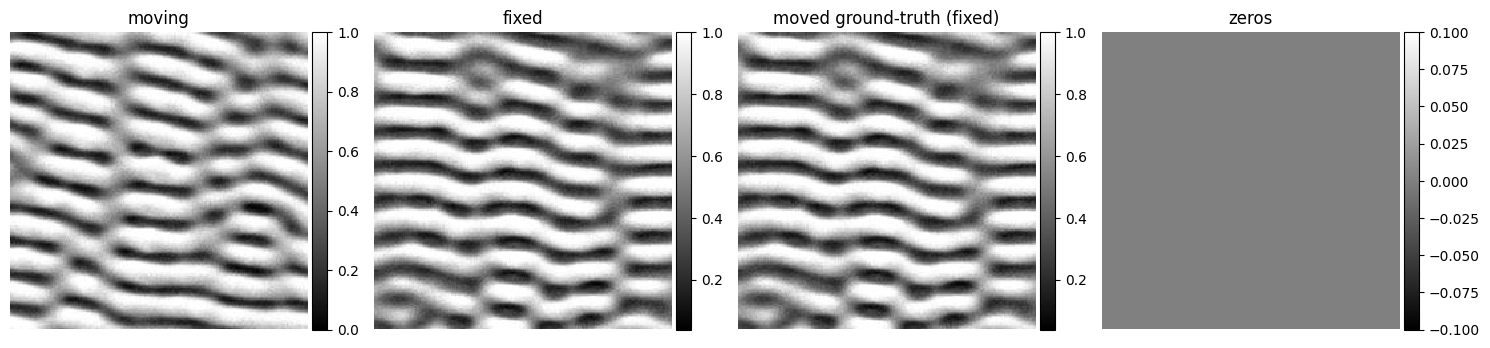

In [16]:
# We can test one of them
in_seq_sample, out_seq_sample = next(train_generator_24_30)

# visualize
images = [img[0, :, :, 0] for img in in_seq_sample + out_seq_sample]
titles = ['moving', 'fixed', 'moved ground-truth (fixed)', 'zeros']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

### Model definition - Support functions
We define the main model and some funtions that will help in the training!

In [13]:
def plot_history(hist, loss_name='loss'):
    # Simple function to plot training history.
    plt.figure()
    plt.plot(hist.epoch, hist.history[loss_name], '.-')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

In [46]:
# First, configure unet input shape (concatenation of moving and fixed images).
ndim = 2
unet_input_features = 2
inshape = (*x_24_30.shape[1:], unet_input_features) # Same shape for all datasets

# configure unet features
nb_features = [
    [64, 128, 256],         # encoder features
    [256, 256, 256, 16]     # decoder features
]

# Let's create model with library
inshape = x_24_30.shape[1:]
vxm_model_24_30 = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)
#vxm_model_22_30 = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)
#vxm_model_20_2 = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)

In [47]:
# Define loss and lambda for the losses (hyper-parameter)
losses = [vxm.losses.MSE().loss, vxm.losses.Grad('l2').loss]
lambda_param = 0.03
loss_weights = [1, lambda_param]
opt1 = tf.keras.optimizers.Adam(learning_rate=1e-4)
#opt2 = tf.keras.optimizers.Adam(learning_rate=1e-4)
#opt3 = tf.keras.optimizers.Adam(learning_rate=1e-4)

In [48]:
# We compile the model
vxm_model_24_30.compile(optimizer=opt1, loss=losses, loss_weights=loss_weights)
#vxm_model_22_30.compile(optimizer=opt2, loss=losses, loss_weights=loss_weights)
#vxm_model_20_2.compile(optimizer=opt3, loss=losses, loss_weights=loss_weights)

### Model Training
We train the model with the different datasets.

In [49]:
# We define the epochs and steps
nb_epochs = 100
steps_per_epoch = 100

Epoch 1/100
100/100 - 10s - loss: 0.1132 - vxm_dense_transformer_loss: 0.1102 - vxm_dense_flow_loss: 0.0995 - 10s/epoch - 104ms/step
Epoch 2/100
100/100 - 6s - loss: 0.0770 - vxm_dense_transformer_loss: 0.0691 - vxm_dense_flow_loss: 0.2650 - 6s/epoch - 64ms/step
Epoch 3/100
100/100 - 6s - loss: 0.0612 - vxm_dense_transformer_loss: 0.0520 - vxm_dense_flow_loss: 0.3064 - 6s/epoch - 64ms/step
Epoch 4/100
100/100 - 6s - loss: 0.0488 - vxm_dense_transformer_loss: 0.0402 - vxm_dense_flow_loss: 0.2880 - 6s/epoch - 65ms/step
Epoch 5/100
100/100 - 7s - loss: 0.0468 - vxm_dense_transformer_loss: 0.0374 - vxm_dense_flow_loss: 0.3115 - 7s/epoch - 65ms/step
Epoch 6/100
100/100 - 6s - loss: 0.0450 - vxm_dense_transformer_loss: 0.0352 - vxm_dense_flow_loss: 0.3251 - 6s/epoch - 61ms/step
Epoch 7/100
100/100 - 6s - loss: 0.0375 - vxm_dense_transformer_loss: 0.0291 - vxm_dense_flow_loss: 0.2805 - 6s/epoch - 64ms/step
Epoch 8/100
100/100 - 6s - loss: 0.0383 - vxm_dense_transformer_loss: 0.0294 - vxm_dens

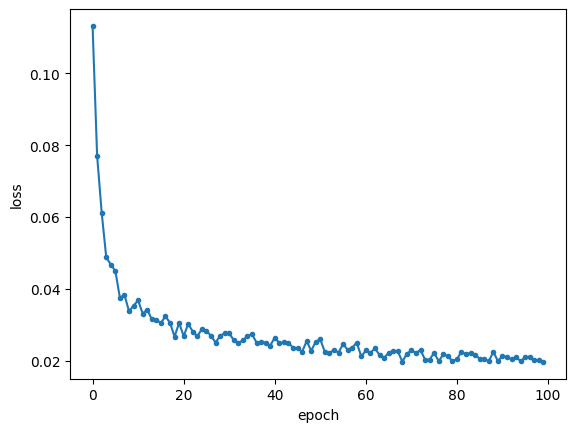

In [50]:
# First, with the laset 24_30 dataset
hist_24_30 = vxm_model_24_30.fit(train_generator_24_30, epochs=nb_epochs, steps_per_epoch=steps_per_epoch, verbose=2)
plot_history(hist_24_30)

In [41]:
# Second, with the laset 22_30 dataset
#hist_22_30 = vxm_model_22_30.fit(train_generator_22_30, epochs=nb_epochs, steps_per_epoch=steps_per_epoch, verbose=2)
#plot_history(hist_22_30)

In [43]:
# Finally, with the laset 20_2 dataset
#hist_20_2 = vxm_model_20_2.fit(train_generator_20_2, epochs=nb_epochs, steps_per_epoch=steps_per_epoch, verbose=2)
#plot_history(hist_20_2)

### Model Prediction
We define do the sequential prediction and save all the results!

In [51]:
def prediction_convert_image(prediction, save_route, id):
    I = prediction[0].squeeze(2)
    I8 = (((I - I.min()) / (I.max() - I.min())) * 255.9).astype(np.uint8)
    img = Image.fromarray(I8)
    img.save(f"{save_route}images/registered_{id}.jpg")

In [52]:
def flow_convert_image(flow, save_route, id):
  I_flow = flow[0, :, :, 0]
  I8_flow = (((I_flow - I_flow.min()) / (I_flow.max() - I_flow.min())) * 255.9).astype(np.uint8)
  img = Image.fromarray(I8_flow)
  img.save(f"{save_route}flow/flow_{id}.jpg")

In [53]:
# - Finally - Let's do the procedure to predict sequentially the data

def sequential_registration(x_data, model, save_route, batch_size=1):
    # preliminary sizing
    amount_data = x_data.shape[0]

    # We predict the first image
    fixed_image = x_data[np.array([0]), ..., np.newaxis]
    moving_image = x_data[np.array([1]), ..., np.newaxis]

    initial_in = [moving_image, fixed_image]

    initial_pred = model.predict(initial_in)

    # Save initial images
    prediction_convert_image(fixed_image, save_route, '1')
    prediction_convert_image(initial_pred[0], save_route, '2')
    flow_convert_image(initial_pred[1], save_route, '1')

    for i in range(2, amount_data):
      moving_image = x_data[np.array([i]), ..., np.newaxis]
      current_in = [moving_image, initial_pred[0]]
      initial_pred = model.predict(current_in)
      prediction_convert_image(initial_pred[0], save_route, str(i+1))
      flow_convert_image(initial_pred[1], save_route, str(i))


In [54]:
# We do it for our first dataset
sequential_registration(x_24_30, vxm_model_24_30, './drive/MyDrive/result_sink/24_30_registered/')

1/1 [==============================] - 0s 36ms/step


In [55]:
# End of notebook!